In [3]:
import numpy as np

from tqdm import tqdm
import progressbar

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics.pairwise import manhattan_distances

import pandas as pd

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [23]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [4]:
data = pd.read_csv('tsp.csv', header=None).drop([0], axis=1)
data.columns = ['x', 'y']

In [11]:
class Hillclimbing(object):
    def __init__(self, max_iter=100, mutations_count=10, objects_to_mutate=10):
        self.max_iter=max_iter
        self.mutations_count=mutations_count
        self.objects_to_mutate=objects_to_mutate
    
    def fit(self, data):
        self.distance_ = manhattan_distances(data)
        self.city_order = list(range(self.distance_.shape[0]))
        self.cost = self.path_cost()
        
        for _ in tqdm(range(self.max_iter)):
            step_res = list()
            for _ in range(self.objects_to_mutate):
                current_order = list(self.city_order)
                for _ in range(self.mutations_count):
                    i = np.random.randint(0, self.distance_.shape[0])
                    j = np.random.randint(0, self.distance_.shape[0])
                    
                    self.swap_cities(current_order, i, j)
                
                current_cost = self.path_cost(current_order)
                step_res.append((self.cost - current_cost, current_cost, current_order))
            
            step_res = sorted(step_res, reverse=True)
            if step_res[0][0] > 0:
                self.cost, self.city_order = step_res[0][1], step_res[0][2]
        
    @staticmethod
    def swap_cities(cities, i, j):
        cities[i], cities[j] = cities[j], cities[i]
    
    def path_cost(self, cities=None):
        if cities is None:
            cities = self.city_order
            
        return np.sum([self.distance_[i, j] for (i, j) in zip(cities[:-1], cities[1:])])

In [14]:
hc = Hillclimbing(max_iter=100000)
hc.fit(data)

100%|██████████| 100000/100000 [01:16<00:00, 1303.72it/s]


76.3356968137


In [47]:
def plot_manhattan(p1, p2):
    angle = angle_between(p1, p2)
    
    if (angle >= 0 and angle < 90) or (angle >= 180 and angle < 270):
        plt.plot([p1[0], p2[0]], [p1[1], p1[1]], color='red')
        plt.plot([p2[0], p2[0]], [p1[1], p2[1]], color='red')
    elif (angle >= 90 and angle < 180) or (angle >= 270 and angle < 360):
        plt.plot([p1[0], p1[0]], [p1[1], p2[1]], color='red')
        plt.plot([p1[0], p2[0]], [p2[1], p2[1]], color='red')   

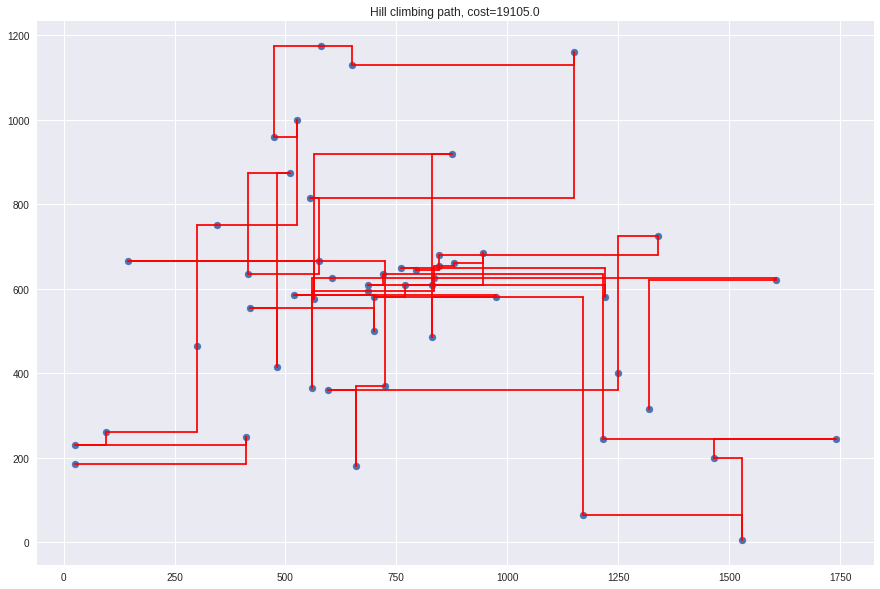

In [49]:
plt.figure(figsize=(15,10))
plt.scatter(data['x'], data['y'])
for p, n in zip(hc.city_order[:-1], hc.city_order[1:]):
    p_x, p_y = data.loc[p,]['x'], data.loc[p,]['y']
    n_x, n_y = data.loc[n,]['x'], data.loc[n,]['y']
    
#     plt.plot([p_x, n_x], [p_y, n_y], color='red')
    plot_manhattan((p_x, p_y), (n_x, n_y))
plt.title('Hill climbing path, cost={}'.format(hc.cost))

In [55]:
class Annealing(object):
    def __init__(self, temp = 100., alpha=0.005, mut_rate=10):
        self.alpha = alpha
        self.tempreture = temp
        self.mutation_rate=mut_rate
    
    def fit(self, data):
        current_temp = self.tempreture
        self.distance_ = manhattan_distances(data)
        self.city_order = list(range(self.distance_.shape[0]))
        self.cost = self.path_cost()
        
        while current_temp > 1.:
            current_order = list(self.city_order)
            step_res = list()
            for _ in range(self.mutation_rate):
                i = np.random.randint(0, self.distance_.shape[0])
                j = np.random.randint(0, self.distance_.shape[0])

                self.swap_cities(current_order, i, j)
                
            current_cost = self.path_cost(current_order)
            if current_cost < self.cost:
                self.city_order = current_order
                self.cost = current_cost
            else:
                current_temp *= (1 - self.alpha)
        
    @staticmethod
    def swap_cities(cities, i, j):
        cities[i], cities[j] = cities[j], cities[i]
    
    def path_cost(self, cities=None):
        if cities is None:
            cities = self.city_order
            
        return np.sum([self.distance_[i, j] for (i, j) in zip(cities[:-1], cities[1:])])

In [58]:
ann = Annealing(alpha=0.00005, temp=1000.)
ann.fit(data)

In [59]:
ann.path_cost()

20045.0

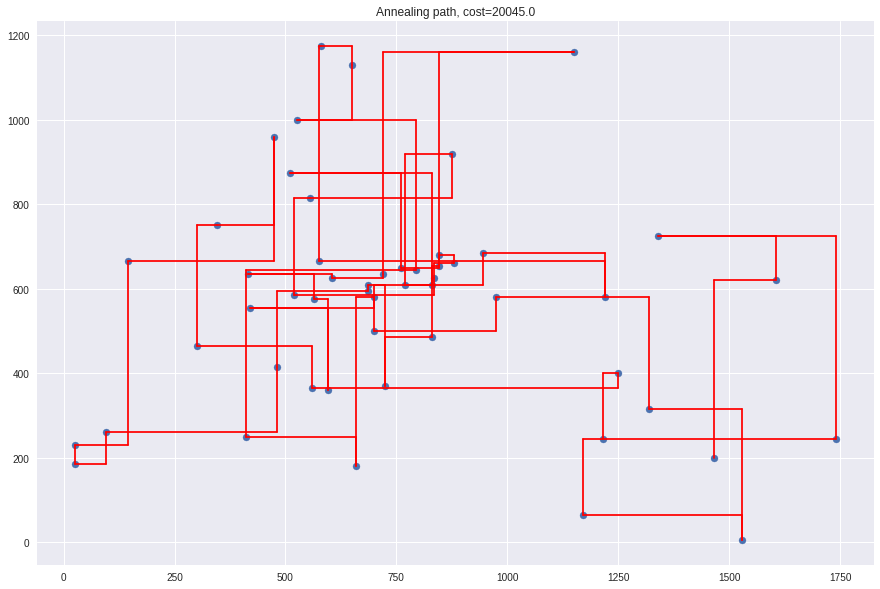

In [62]:
plt.figure(figsize=(15,10))
plt.scatter(data['x'], data['y'])
for p, n in zip(ann.city_order[:-1], ann.city_order[1:]):
    p_x, p_y = data.loc[p,]['x'], data.loc[p,]['y']
    n_x, n_y = data.loc[n,]['x'], data.loc[n,]['y']
    
    plot_manhattan([p_x, p_y], [n_x, n_y])
plt.title('Annealing path, cost={}'.format(ann.cost))

In [78]:
class Genetic(object):
    def __init__(self, max_iter=100, mutations_count=10, candidates=10, surv_rate=0.25):
        self.max_iter=max_iter
        self.candidates=candidates
        self.survaviors_count=int(candidates*surv_rate)
        self.mutations_count=mutations_count
    
    def fit(self, data):
        self.distance_ = manhattan_distances(data)
        
        survaviors = [self.random_order() for _ in range(self.candidates)]
        progress = progressbar.ProgressBar()
        for _ in progress(range(self.max_iter)):                
            survaviors = sorted(survaviors, key = lambda s: self.path_cost(s))[:self.survaviors_count]
            while len(survaviors) < self.candidates:
                i = np.random.randint(0, self.survaviors_count)
                j = np.random.randint(0, self.survaviors_count)
                
                survaviors.append(self.cross(survaviors[i], survaviors[j]))
                
        self.city_order = survaviors[0]
        self.cost = self.path_cost()
    
    @staticmethod
    def cross(first, second):
        first = np.array(first)
        second = np.array(second)
        mask = np.random.binomial(1, 0.5, size=len(first)).astype(bool)
        
        res = np.array([None]*first.shape[0])
        res[mask] = first[mask]
        j = 0
        for i in range(res.shape[0]):
            if res[i] is None:
                while j < second.shape[0]:
                    if second[j] not in res:
                        res[i] = second[j]
                        j += 1
                        break
                    j += 1
        
        return res               
                
    def random_order(self):
        return list(np.random.permutation(self.distance_.shape[0]))
                
    @staticmethod
    def swap_cities(cities, i, j):
        cities[i], cities[j] = cities[j], cities[i]
    
    def path_cost(self, cities=None):
        if cities is None:
            cities = self.city_order
            
        return np.sum([self.distance_[i, j] for (i, j) in zip(cities[:-1], cities[1:])])

In [88]:
gen = Genetic(max_iter=100000, mutations_count=10, candidates=30, surv_rate=0.5)
gen.fit(data)

100% |########################################################################|


In [93]:
gen.path_cost()

21990.0

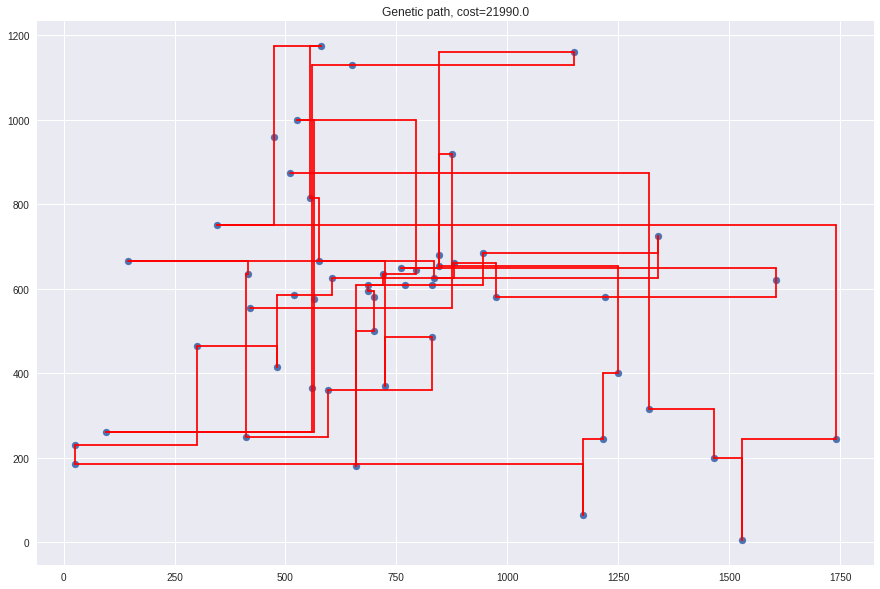

In [94]:
plt.figure(figsize=(15,10))
plt.scatter(data['x'], data['y'])
for p, n in zip(gen.city_order[:-1], gen.city_order[1:]):
    p_x, p_y = data.loc[p,]['x'], data.loc[p,]['y']
    n_x, n_y = data.loc[n,]['x'], data.loc[n,]['y']
    
    plot_manhattan([p_x, p_y], [n_x, n_y])
plt.title('Genetic path, cost={}'.format(gen.cost))